### 1. Four classifier: original, one with only sleep as feature, one only train on sleep class and one only train on awake class.

### 2. For 231 and 222_1, sleep classifier performs better than the awake classifier. 

### 3. For original classifier, the accuracy for sleep class is lower than that for awake class

### 4. Consider stratified both sleep class and label

In [2]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator

from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import jj_basic_fn as JJ
from sklearn import ensemble
import seaborn as sns
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv
from sklearn.metrics import roc_curve, auc


import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules

#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7
import pickle

/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hp/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


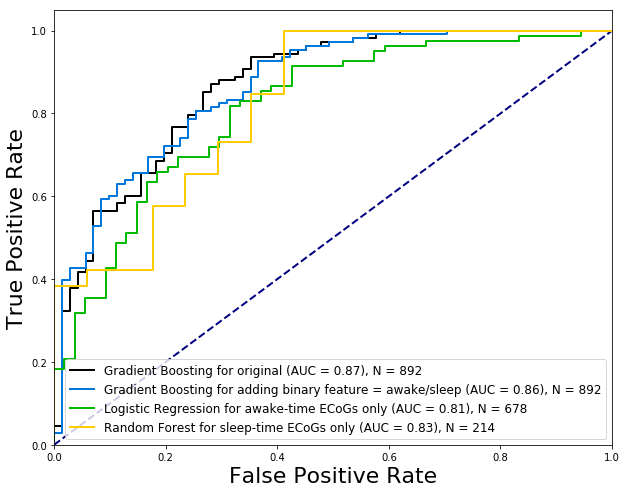

In [5]:
pat_id = '231'
p_sleep_a = pickle.load(open(hp.prepath_pat + pat_id +'_trainedP1_sleep_awake.p', "rb" ))
p_sleep_s = pickle.load(open(hp.prepath_pat + pat_id +'_trainedP1_sleep_sleep.p', "rb" ))
p_sleep = pickle.load(open(hp.prepath_pat + pat_id +'_trainedP1_sleep.p', "rb" ))
p = pickle.load(open(hp.prepath_pat + pat_id + '_trainedP1.p', "rb" ))
#original, use as a feature, awake, sleep
pat_list = [p,p_sleep,p_sleep_a,p_sleep_s]
#pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

cmap = plot_funcs.get_cmap(len(pat_list) + 1, name = 'nipy_spectral')
lw = 2
plt.figure()
ax = plt.subplot(111)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
for i,pat in enumerate(pat_list):
    
    X_train, X_test, y_train, y_test = pat.X_train, pat.X_test, pat.y_train, pat.y_test
    num = y_test.shape[0] + y_train.shape[0]
    JJ.scores_estimators(X_test, y_test, pat= pat, if_show = 0,if_save = 0)
    
    if i == 0:
        label = hp.int2name[pat.best_estimator] + ' for original'
    elif i == 1:
        label = hp.int2name[pat.best_estimator] + ' for adding binary feature = awake/sleep'
    elif i == 2:
        label = hp.int2name[pat.best_estimator] + ' for awake-time ECoGs only'
    elif i ==3:
        label = hp.int2name[pat.best_estimator] + ' for sleep-time ECoGs only'
        
#     print('scores for ' + label)
    
    y_score, accuracy, y_pred, clf_name = JJ.load_score(pat.best_estimator, X_test, y_test, pat)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)        
    
#     plt.plot(fpr, tpr, color=cmap(i),
#            lw=lw, label='%s (AUC = %0.2f)' % (label, roc_auc))
    plt.plot(fpr, tpr, color=cmap(i),
           lw=lw, label='%s (AUC = %0.2f), N = %d' % (label, roc_auc, num))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=hp.label_fontsize)
plt.ylabel('True Positive Rate', fontsize=hp.label_fontsize)
#plt.title(pat.id +' Receiver operating characteristic curve', fontsize=hp.label_fontsize)

plt.legend(prop={'size': 12})
plt.savefig('../fig/sleep/' + pat.id + '_ROC.png')
plt.show()

[[ 0.03783489  0.          0.16922493  0.          0.         -0.85074502
   0.2906497   0.15868867  0.          0.          0.          0.
   0.14458266  0.          0.          0.          0.          0.
  -1.05685219 -0.81051818  0.          0.          0.          0.
   0.          0.          0.0031067  -0.06617476  0.          0.
  -0.28189526  0.          0.          0.41939745 -0.06158069  0.09921074
   0.01822619 -0.07158968  0.25333381  0.01209584 -0.0843252  -0.1504802
   0.          0.          0.          0.          0.05977681  0.
   0.          0.01366178 -0.24737041  0.0723906  -0.04532549 -0.15418489]]


<Figure size 720x576 with 0 Axes>

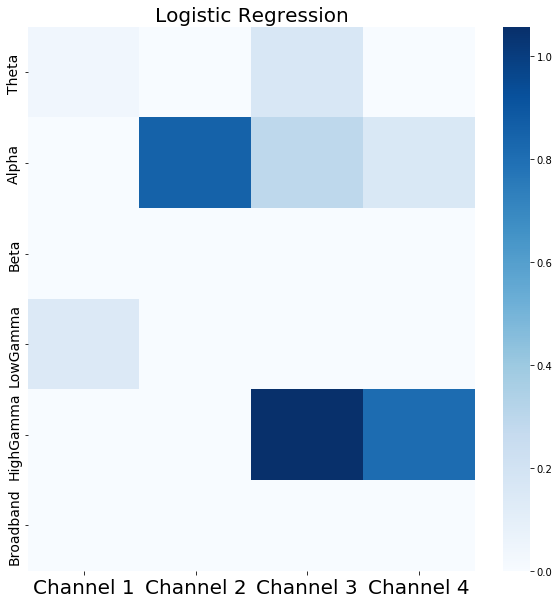

<Figure size 720x576 with 0 Axes>

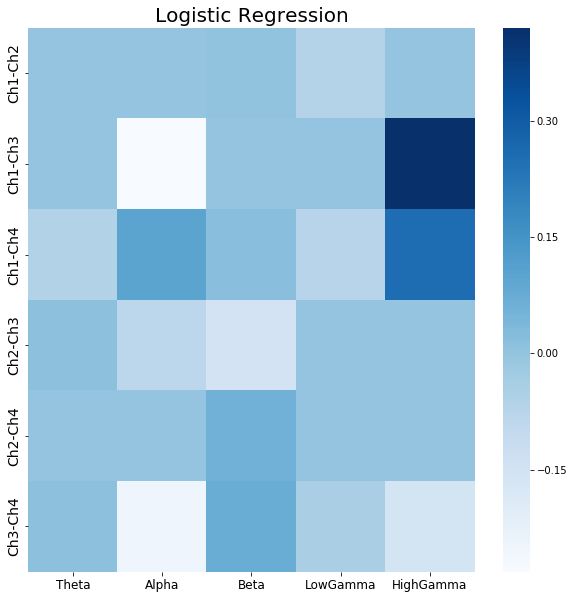

['HighGamma3', 'Alpha2']
The 3 most important features for Logistic Regression are Alpha2, HighGamma3, 
[[0.03783489 0.         0.16922493 0.        ]
 [0.         0.85074502 0.2906497  0.15868867]
 [0.         0.         0.         0.        ]
 [0.14458266 0.         0.         0.        ]
 [0.         0.         1.05685219 0.81051818]
 [0.         0.         0.         0.        ]]


<Figure size 720x576 with 0 Axes>

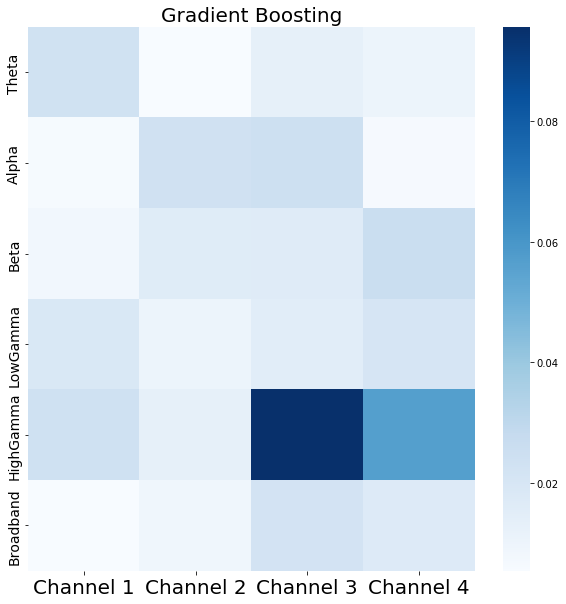

<Figure size 720x576 with 0 Axes>

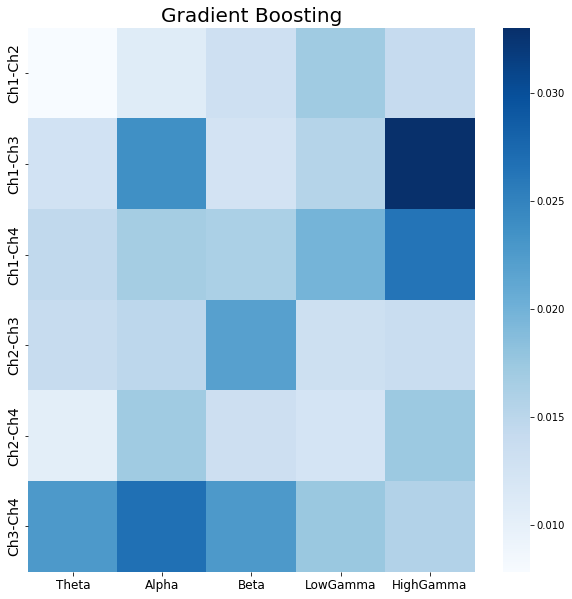

['HighGamma3', 'Alpha2']
The 3 most important features for Gradient Boosting are HighGamma4, HighGamma3, 
[[0.02332614 0.00542143 0.01323689 0.01056838]
 [0.00625135 0.02369783 0.02469784 0.00676433]
 [0.00859202 0.01614826 0.01660241 0.02607289]
 [0.01901981 0.01070137 0.0155086  0.02068179]
 [0.02396042 0.01335156 0.09561061 0.05659043]
 [0.00574993 0.00897731 0.02231668 0.0172753 ]]
[[-0.15228962  0.          0.          0.14558929  0.          0.
  -0.73149486  0.25830957  0.13640566  0.          0.          0.
   0.          0.10758343  0.          0.          0.          0.
   0.         -1.05547335 -0.78004917  0.          0.          0.
   0.          0.          0.          0.         -0.04674568  0.
   0.         -0.27279696  0.          0.          0.38450729 -0.05646321
   0.09062204  0.         -0.06031408  0.24380079  0.00308914 -0.07101172
  -0.1400069   0.          0.          0.          0.          0.06005026
   0.          0.          0.00147204 -0.23832283  0.055076

<Figure size 720x576 with 0 Axes>

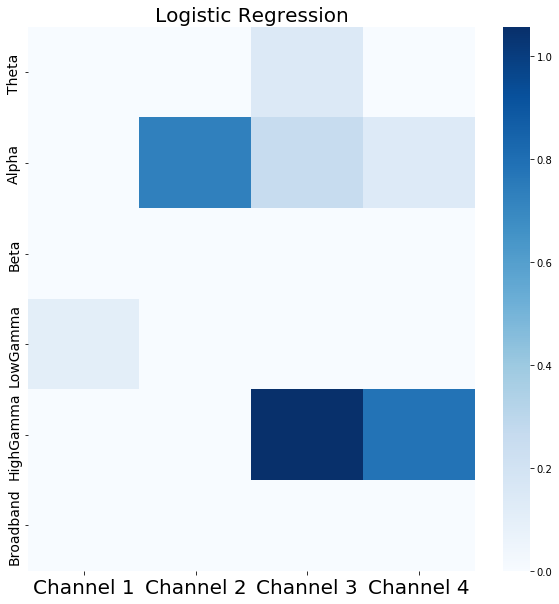

<Figure size 720x576 with 0 Axes>

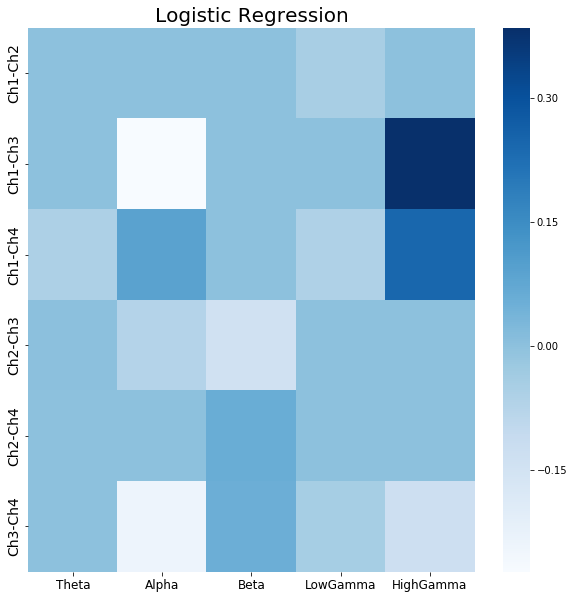

['HighGamma3', 'HighGamma4']
The 3 most important features for Logistic Regression are HighGamma4, HighGamma3, 
[[0.         0.         0.14558929 0.        ]
 [0.         0.73149486 0.25830957 0.13640566]
 [0.         0.         0.         0.        ]
 [0.10758343 0.         0.         0.        ]
 [0.         0.         1.05547335 0.78004917]
 [0.         0.         0.         0.        ]]


<Figure size 720x576 with 0 Axes>

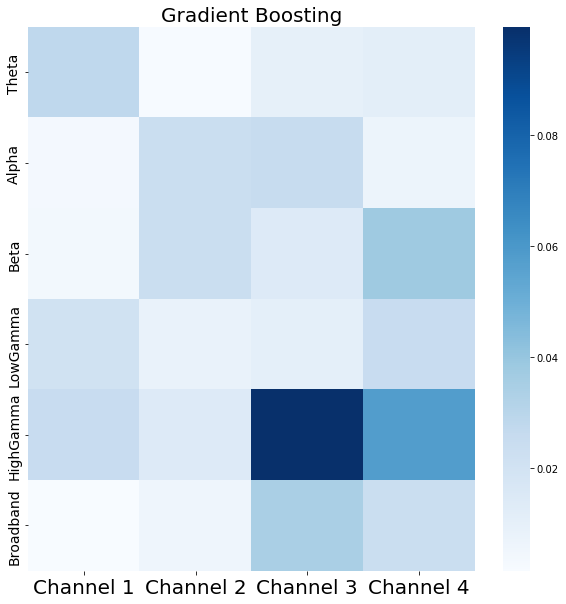

<Figure size 720x576 with 0 Axes>

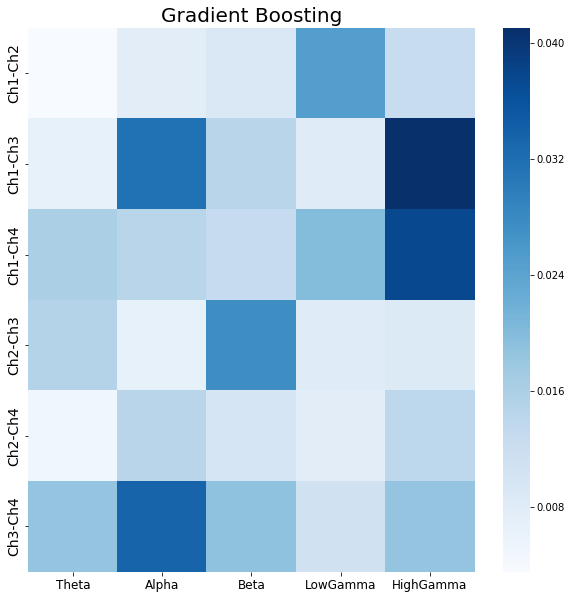

['HighGamma3', 'HighGamma4']
The 3 most important features for Gradient Boosting are HighGamma4, HighGamma3, 
[[0.028  0.002  0.01   0.0115]
 [0.0035 0.024  0.0255 0.007 ]
 [0.004  0.024  0.0145 0.038 ]
 [0.021  0.0085 0.011  0.025 ]
 [0.025  0.0145 0.0995 0.058 ]
 [0.0015 0.006  0.0345 0.024 ]]
[[ 0.          0.          0.17833397  0.          0.         -0.39418642
   0.          0.01651735  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -1.03787107 -0.75828096  0.          0.          0.          0.
  -0.03453692  0.          0.          0.          0.          0.
  -0.07956493  0.          0.          0.278508   -0.1159061   0.07292741
   0.          0.          0.29385686 -0.01112261  0.          0.
  -0.00749519  0.         -0.02064648  0.          0.04214272  0.
   0.          0.         -0.20061666  0.06753127 -0.08303248 -0.08325827]]


<Figure size 720x576 with 0 Axes>

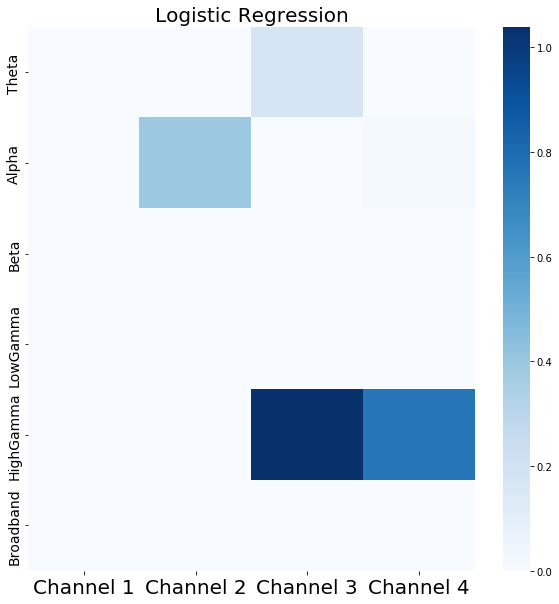

<Figure size 720x576 with 0 Axes>

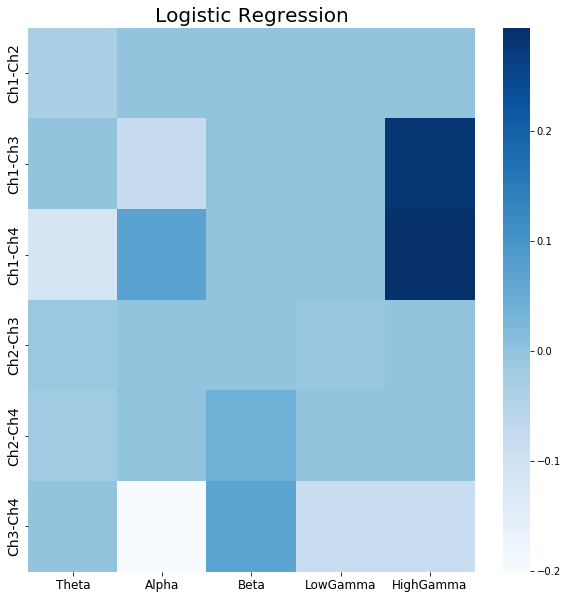

['HighGamma3', 'HighGamma4']
The 3 most important features for Logistic Regression are HighGamma4, HighGamma3, 
[[0.         0.         0.17833397 0.        ]
 [0.         0.39418642 0.         0.01651735]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         1.03787107 0.75828096]
 [0.         0.         0.         0.        ]]


<Figure size 720x576 with 0 Axes>

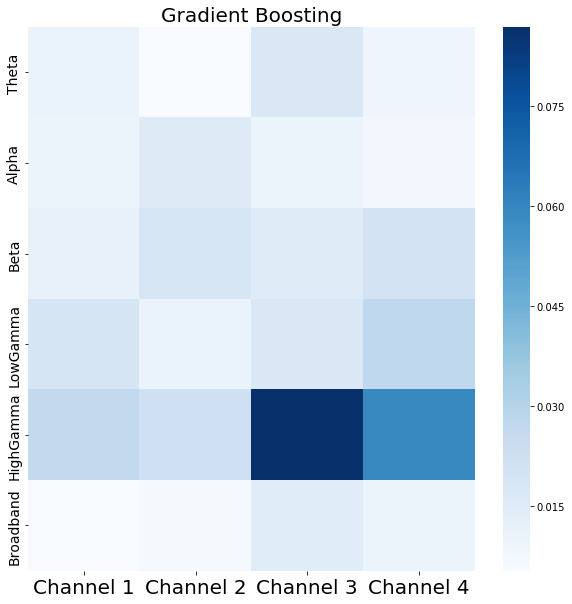

<Figure size 720x576 with 0 Axes>

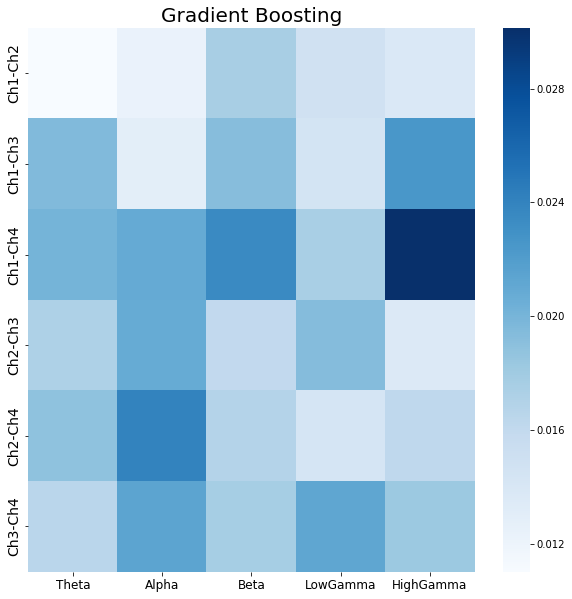

['HighGamma3', 'HighGamma4']
The 3 most important features for Gradient Boosting are HighGamma4, HighGamma3, 
[[0.01071911 0.00550898 0.017132   0.00882167]
 [0.00994607 0.01552155 0.01006412 0.00810889]
 [0.01150306 0.01834996 0.01497904 0.02029243]
 [0.01912651 0.0105953  0.01712083 0.02731863]
 [0.0266629  0.02238116 0.08679274 0.05897439]
 [0.00529489 0.00668711 0.01467957 0.00992829]]
[[-0.4623477  -0.49846618  0.61157688  0.18064051 -0.53961223 -0.40799093
   0.38369618  0.06986118  0.20760332  0.61200452 -0.47729596  0.48169755
   0.32883923  0.60755351 -0.64041794 -0.23361053 -0.30634777 -0.01103668
  -0.86897194 -0.81880238  0.0275923  -0.07428866  0.42942242  0.20897189
   0.30926551  0.50678844 -0.07781558 -0.13540183  0.07006564 -0.00733912
  -0.39071738  0.10829476  0.00601299  0.16553433 -0.05882392  0.12474456
   0.37869665 -0.14285374  0.28296367  0.1775998  -0.4218976  -0.43703586
   0.04481388  0.11996761  0.05982762 -0.59107211 -0.17886944  0.21434357
   0.16918004 -

<Figure size 720x576 with 0 Axes>

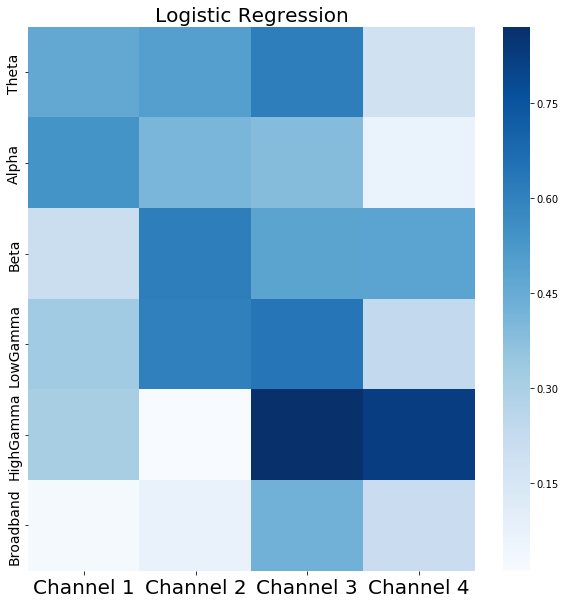

<Figure size 720x576 with 0 Axes>

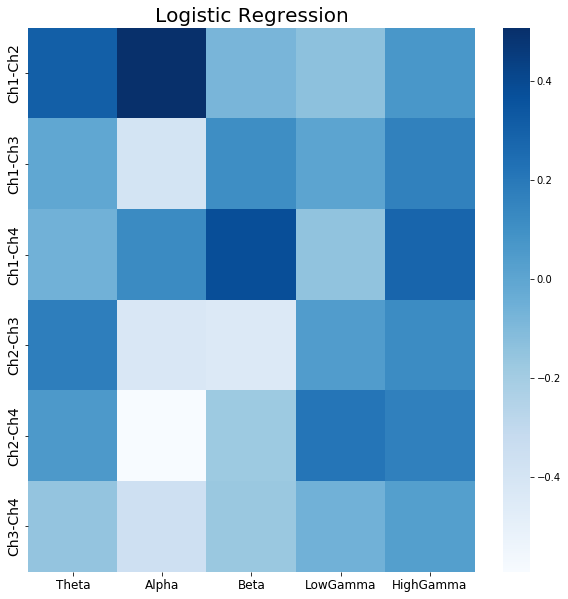

['HighGamma3', 'HighGamma4']
The 3 most important features for Logistic Regression are HighGamma4, HighGamma3, 
[[0.4623477  0.49846618 0.61157688 0.18064051]
 [0.53961223 0.40799093 0.38369618 0.06986118]
 [0.20760332 0.61200452 0.47729596 0.48169755]
 [0.32883923 0.60755351 0.64041794 0.23361053]
 [0.30634777 0.01103668 0.86897194 0.81880238]
 [0.0275923  0.07428866 0.42942242 0.20897189]]


<Figure size 720x576 with 0 Axes>

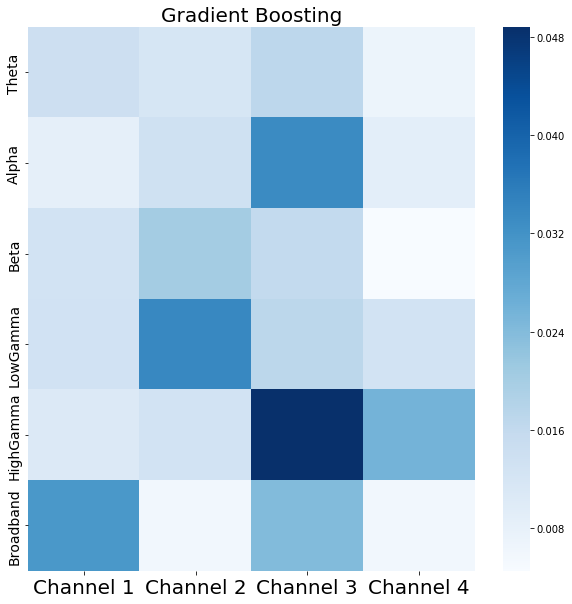

<Figure size 720x576 with 0 Axes>

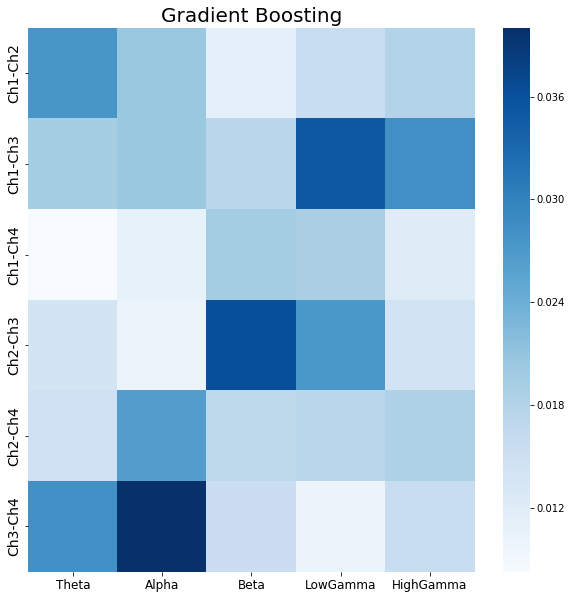

['HighGamma3', 'HighGamma4']
The 3 most important features for Gradient Boosting are LowGamma2, HighGamma3, 
[[0.01412884 0.01184874 0.01681002 0.00702278]
 [0.00867353 0.01366427 0.0332509  0.00888038]
 [0.01297174 0.02041706 0.01599695 0.00452999]
 [0.013126   0.03384771 0.01709588 0.0128605 ]
 [0.01073357 0.01287859 0.04877614 0.02564807]
 [0.03098014 0.00606071 0.02418935 0.00608461]]


In [45]:
if_abs = 1
if_save = 0
if_title = 1
sleep_list = [0,1,0,0]
for i,pat in enumerate(pat_list):
    plot_funcs.feature_importance(pat, 1, if_save = if_save, if_abs = if_abs, if_title = if_title, if_plv = 1, if_sleep = sleep_list[i])
    plot_funcs.feature_importance(pat, 7, if_save = if_save, if_abs = if_abs, if_title = if_title, if_plv = 1, if_sleep = sleep_list[i])


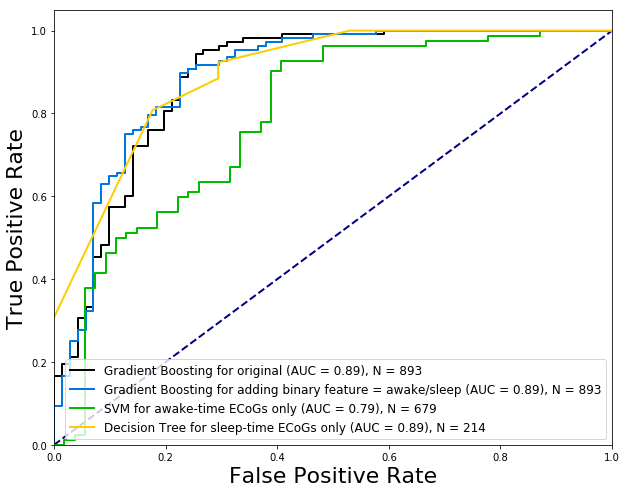

In [24]:
pat_id = '231'
p_sleep_a = pickle.load(open(hp.prepath_pat + pat_id +'_trained_sleep_awake.p', "rb" ))
p_sleep_s = pickle.load(open(hp.prepath_pat + pat_id +'_trained_sleep_sleep.p', "rb" ))
p_sleep = pickle.load(open(hp.prepath_pat + pat_id +'_trained_sleep.p', "rb" ))
p = pickle.load(open(hp.prepath_pat + pat_id + '_trained.p', "rb" ))
#original, use as a feature, awake, sleep
pat_list = [p,p_sleep,p_sleep_a,p_sleep_s]
#pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

cmap = plot_funcs.get_cmap(len(pat_list) + 1, name = 'nipy_spectral')
lw = 2
plt.figure()
ax = plt.subplot(111)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
for i,pat in enumerate(pat_list):
    
    X_train, X_test, y_train, y_test = pat.X_train, pat.X_test, pat.y_train, pat.y_test
    num = y_test.shape[0] + y_train.shape[0]
    JJ.scores_estimators(X_test, y_test, pat= pat, if_show = 0,if_save = 0)
    
    if i == 0:
        label = hp.int2name[pat.best_estimator] + ' for original'
    elif i == 1:
        label = hp.int2name[pat.best_estimator] + ' for adding binary feature = awake/sleep'
    elif i == 2:
        label = hp.int2name[pat.best_estimator] + ' for awake-time ECoGs only'
    elif i ==3:
        label = hp.int2name[pat.best_estimator] + ' for sleep-time ECoGs only'
        
#     print('scores for ' + label)
    
    y_score, accuracy, y_pred, clf_name = JJ.load_score(pat.best_estimator, X_test, y_test, pat)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)        
    
#     plt.plot(fpr, tpr, color=cmap(i),
#            lw=lw, label='%s (AUC = %0.2f)' % (label, roc_auc))
    plt.plot(fpr, tpr, color=cmap(i),
           lw=lw, label='%s (AUC = %0.2f), N = %d' % (label, roc_auc, num))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=hp.label_fontsize)
plt.ylabel('True Positive Rate', fontsize=hp.label_fontsize)
#plt.title(pat.id +' Receiver operating characteristic curve', fontsize=hp.label_fontsize)

plt.legend(prop={'size': 12})
plt.savefig('../fig/sleep/' + pat.id + '_ROC.png')
plt.show()

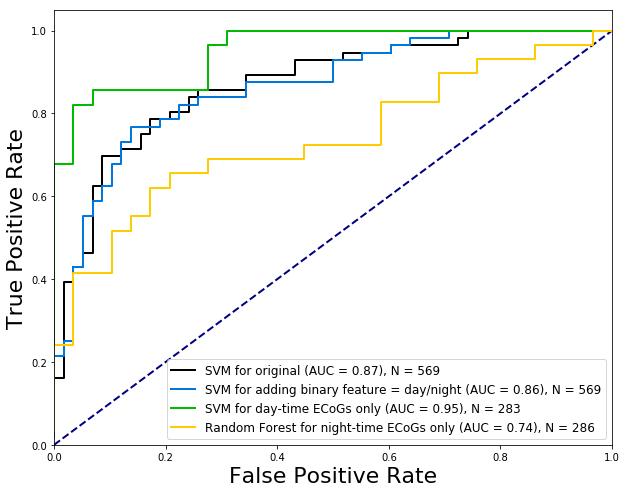

In [25]:
pat_id = '241'
p_sleep_a = pickle.load(open(hp.prepath_pat + pat_id +'_trained_sleep_awake.p', "rb" ))
p_sleep_s = pickle.load(open(hp.prepath_pat + pat_id +'_trained_sleep_sleep.p', "rb" ))
p_sleep = pickle.load(open(hp.prepath_pat + pat_id +'_trained_sleep.p', "rb" ))
p = pickle.load(open(hp.prepath_pat + pat_id + '_trained.p', "rb" ))
#original, use as a feature, awake, sleep
pat_list = [p,p_sleep,p_sleep_a,p_sleep_s]
#pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

cmap = plot_funcs.get_cmap(len(pat_list) + 1, name = 'nipy_spectral')
lw = 2
plt.figure()
ax = plt.subplot(111)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
for i,pat in enumerate(pat_list):
    
    X_train, X_test, y_train, y_test = pat.X_train, pat.X_test, pat.y_train, pat.y_test
    num = y_test.shape[0] + y_train.shape[0]
    JJ.scores_estimators(X_test, y_test, pat= pat, if_show = 0,if_save = 0)
    
    if i == 0:
        label = hp.int2name[pat.best_estimator] + ' for original'
    elif i == 1:
        label = hp.int2name[pat.best_estimator] + ' for adding binary feature = day/night'
    elif i == 2:
        label = hp.int2name[pat.best_estimator] + ' for day-time ECoGs only'
    elif i ==3:
        label = hp.int2name[pat.best_estimator] + ' for night-time ECoGs only'
        
#     print('scores for ' + label)
    
    y_score, accuracy, y_pred, clf_name = JJ.load_score(pat.best_estimator, X_test, y_test, pat)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)        
    
#     plt.plot(fpr, tpr, color=cmap(i),
#            lw=lw, label='%s (AUC = %0.2f)' % (label, roc_auc))
    plt.plot(fpr, tpr, color=cmap(i),
           lw=lw, label='%s (AUC = %0.2f), N = %d' % (label, roc_auc, num))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=hp.label_fontsize)
plt.ylabel('True Positive Rate', fontsize=hp.label_fontsize)
#plt.title(pat.id +' Receiver operating characteristic curve', fontsize=hp.label_fontsize)

plt.legend(prop={'size': 12})
plt.savefig('../fig/sleep/' + pat.id + '_ROC.png')
plt.show()

In [2]:
import pickle
p231_sleep_a = pickle.load(open(hp.prepath_pat + '231' +'_trained_sleep_awake.p', "rb" ))
p231_sleep_s = pickle.load(open(hp.prepath_pat + '231' +'_trained_sleep_sleep.p', "rb" ))
p231_sleep = pickle.load(open(hp.prepath_pat + '231' +'_trained_sleep.p', "rb" ))
p231 = pickle.load(open(hp.prepath_pat + '231' +'_trained.p', "rb" ))

p222_sleep_a = pickle.load(open(hp.prepath_pat + '222_1' +'_trained_sleep_awake.p', "rb" ))
p222_sleep_s = pickle.load(open(hp.prepath_pat + '222_1' +'_trained_sleep_sleep.p', "rb" ))
p222_sleep = pickle.load(open(hp.prepath_pat + '222_1' +'_trained_sleep.p', "rb" ))
p222 = pickle.load(open(hp.prepath_pat + '222_1' +'_trained.p', "rb" ))

In [3]:
#four classifier: original, one with only sleep as feature
pat = p231
X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
clf = pat.estimator[7]
pred = clf.predict(X_test[:, 1:29])
print('Accuracy for predicting sleep class is ', np.sum(X_test[pred == y_test,0] > 0)/np.sum(X_test[:,0] > 0)) #sleep
print('Accuracy for predicting awake class is ', np.sum(X_test[pred == y_test,0] < 0)/np.sum(X_test[:,0] < 0)) #awake
print('sleep total', np.sum(X_test[:,0] > 0))
print('awake total', np.sum(X_test[:,0] < 0))
pat = p222
X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
clf = pat.estimator[2]
pred = clf.predict(X_test[:, 1:29])
print('Accuracy for predicting sleep class is ', np.sum(X_test[pred == y_test,0] > 0)/np.sum(X_test[:,0] > 0)) #sleep
print('Accuracy for predicting awake class is ', np.sum(X_test[pred == y_test,0] < 0)/np.sum(X_test[:,0] < 0)) #awake


Accuracy for predicting sleep class is  0.825
Accuracy for predicting awake class is  0.8848920863309353
sleep total 40
awake total 139
Accuracy for predicting sleep class is  0.7291666666666666
Accuracy for predicting awake class is  0.7142857142857143


0
scores for gradient boosting for original
1
scores for gradient boosting for using sleep as feature
2
scores for random forest for awake time
3
scores for decision tree for sleep time


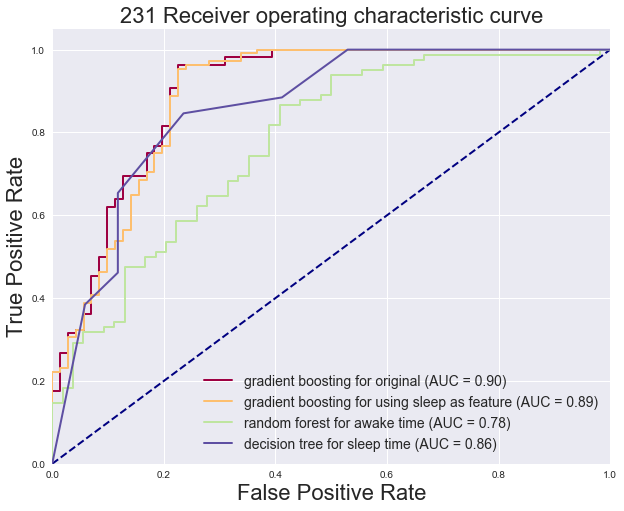

In [18]:
#
from sklearn.metrics import mean_squared_error, make_scorer, roc_curve, auc

pat_list = [p231,p231_sleep,p231_sleep_s,p231_sleep_a]
#pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

cmap = plot_funcs.get_cmap(len(pat_list))
lw = 2
plt.figure()
ax = plt.subplot(111)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
for i,pat in enumerate(pat_list):
    print(i)
    if i == 3:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 1)
        classifier_int = 5
        label = hp.int2name[classifier_int] + ' for sleep time'
    elif i == 2:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 0)
        classifier_int = 6
        label = hp.int2name[classifier_int] + ' for awake time'
    elif i == 1:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
        classifier_int = 7
        label = hp.int2name[classifier_int] + ' for using sleep as feature'
    elif i ==0:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1)
        classifier_int = 7
        label = hp.int2name[classifier_int] + ' for original'
    print('scores for ' + label)
#    JJ.scores_estimators(X_test, y_test, pat = pat)
#     if i != 1:
#         plot_funcs.feature_importance(pat,classifier_int)
    y_score, accuracy, y_pred, clf_name = JJ.load_score(classifier_int, X_test, y_test, pat)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)        
    
    plt.plot(fpr, tpr, color=cmap(i),
           lw=lw, label='%s (AUC = %0.2f)' % (label, roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.xlabel('False Positive Rate', fontsize=hp.label_fontsize)
    plt.ylabel('True Positive Rate', fontsize=hp.label_fontsize)
    plt.title(pat.id +' Receiver operating characteristic curve', fontsize=hp.label_fontsize)

plt.legend(prop={'size': 14})
plt.savefig('../fig/sleep/' + pat.id + '_ROC.png')
plt.show()

scores for 231 original


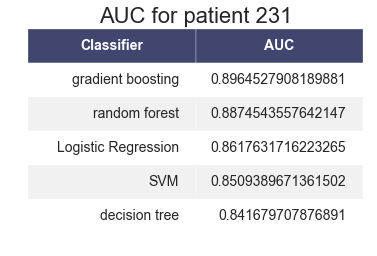

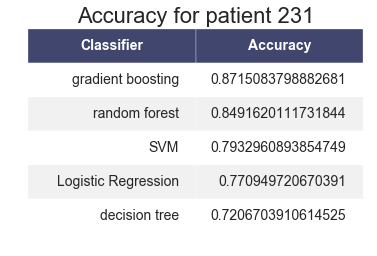

scores for 231 use sleep as feature


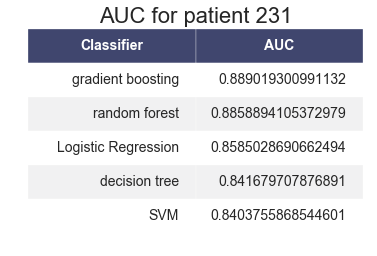

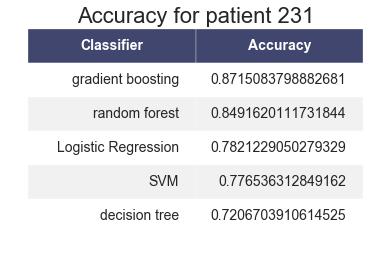

scores for 231 classifier for awake time


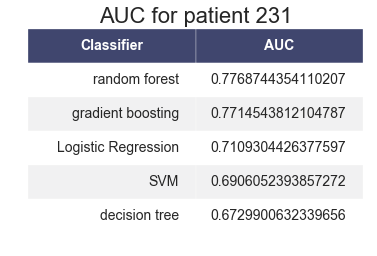

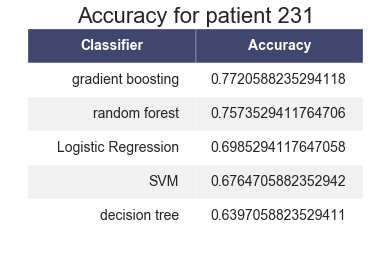

scores for 231 classifier for sleep time


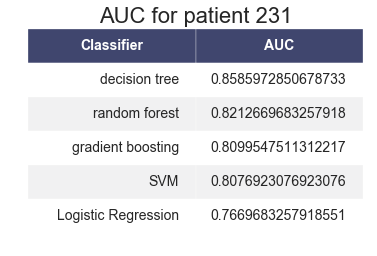

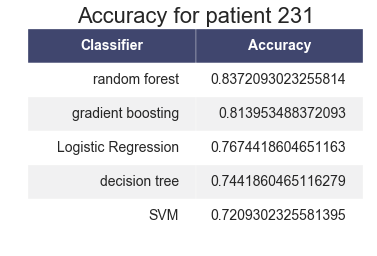

In [17]:
from sklearn.metrics import mean_squared_error, make_scorer, roc_curve, auc

pat_list = [p231,p231_sleep,p231_sleep_s,p231_sleep_a]
#pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

for i,pat in enumerate(pat_list):
    if i == 3:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 1)
        classifier_int = 1
        label = pat.id + ' ' + 'classifier for sleep time'
    elif i == 2:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 0)
        classifier_int = 1
        label = pat.id + ' ' + 'classifier for awake time'
    elif i == 1:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
        classifier_int = 2
        label = pat.id + ' ' + 'use sleep as feature'
    elif i ==0:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1)
        classifier_int = 2
        label = pat.id + ' ' + 'original'
    print('scores for ' + label)
    JJ.scores_estimators(X_test, y_test, pat = pat)


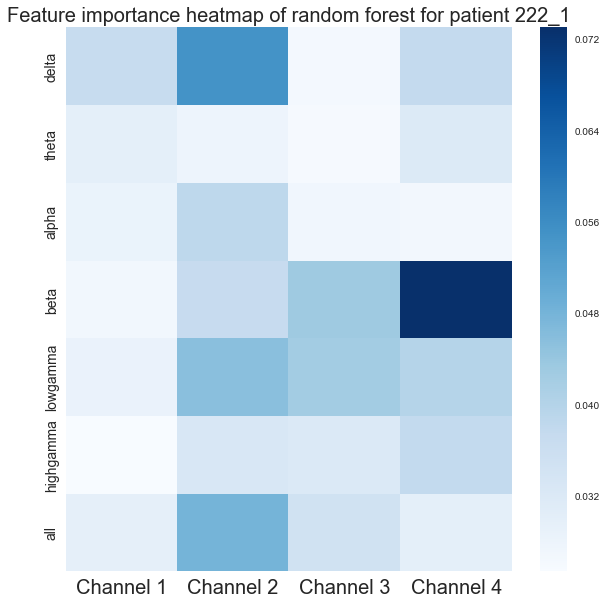

The 3 most important features for random forest are, all Channel 2 , delta Channel 2 , beta Channel 4 


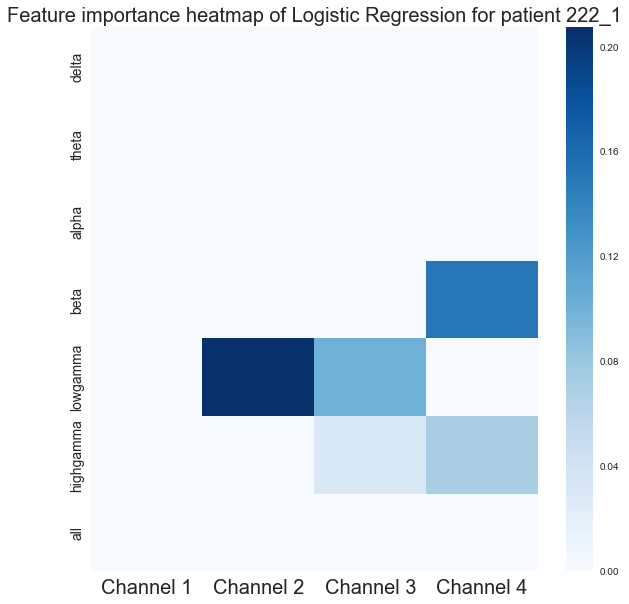

The 3 most important features for Logistic Regression are, lowgamma Channel 3 , beta Channel 4 , lowgamma Channel 2 


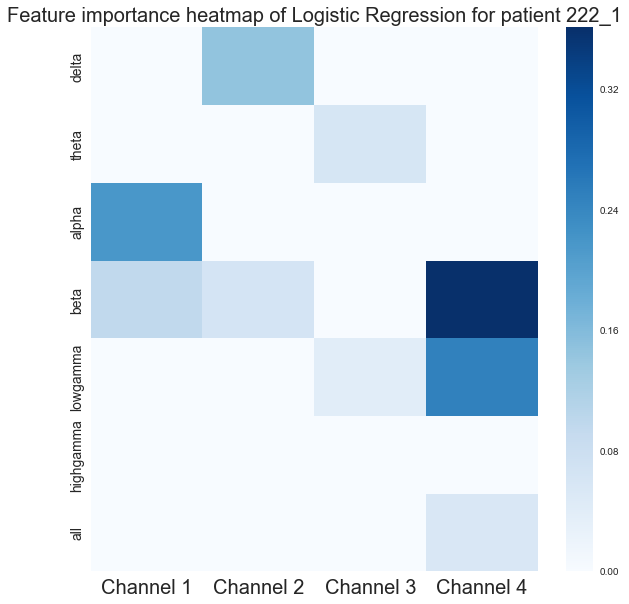

The 3 most important features for Logistic Regression are, alpha Channel 1 , lowgamma Channel 4 , beta Channel 4 


In [8]:
from sklearn.metrics import mean_squared_error, make_scorer, roc_curve, auc

pat_list = [p231,p231_sleep,p231_sleep_s,p231_sleep_a]
pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

for i,pat in enumerate(pat_list):
    if i == 3:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 1)
        classifier_int = 1
        label = pat.id + ', ' + 'sleep time classifier'
    elif i == 2:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 0)
        classifier_int = 1
        label = pat.id + ', ' + 'awake time classifier'
    elif i == 1:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
        classifier_int = 2
        label = pat.id + ', ' + 'use sleep as feature'
    elif i ==0:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1)
        classifier_int = 6
        label = pat.id + ', ' + 'original'
    if i != 1:
        plot_funcs.feature_importance(pat,classifier_int, label)